
               🚀 ADVANCED DEEP LEARNING WYCKOFF ANALYSIS 🚀
✅ Successfully loaded 729 records for CPALL

STEP 1: Advanced Feature Engineering (35+ features)
✅ Created 77 columns

STEP 2: Smart Target Labeling

TARGET DISTRIBUTION (Multi-Strategy Voting)
Normal          :   290 ( 46.03%)
Accumulation    :   210 ( 33.33%)
Distribution    :   130 ( 20.63%)

STEP 3: Hybrid Model Training (LSTM+GRU)

📊 Original dataset: 600 samples
🔄 Applying data augmentation...
📈 Augmented dataset: 2550 samples

⚖️  Class Weights:
   Class 0: 0.756
   Class 1: 0.994
   Class 2: 1.491

🏗️  Model Architecture:
   Total Parameters: 230,499

🚀 Training Advanced Deep Learning Model...
Epoch 1/120
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4195 - loss: 9.4104
Epoch 1: val_accuracy improved from None to 0.30000, saving model to best_wyckoff_dl_model.h5



Epoch 1: finished saving model to best_wyckoff_dl_model.h5
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.4651 - loss: 9.0801 - val_accuracy: 0.3000 - val_loss: 8.8947 - learning_rate: 3.0000e-04
Epoch 2/120
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5122 - loss: 8.2660
Epoch 2: val_accuracy did not improve from 0.30000
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.5341 - loss: 8.0427 - val_accuracy: 0.2778 - val_loss: 8.0589 - learning_rate: 3.0000e-04
Epoch 3/120
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5594 - loss: 7.3876
Epoch 3: val_accuracy did not improve from 0.30000
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.5776 - loss: 7.1816 - val_accuracy: 0.1667 - val_loss: 7.3390 - learning_rate: 3.0000e-04
Epoch 4/120
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5708 - loss: 6.5792
Epoch 4: val_accuracy did not improve from 0.30000
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.5890 - loss: 6.3855 - val_ac


Epoch 7: finished saving model to best_wyckoff_dl_model.h5
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.6412 - loss: 4.3865 - val_accuracy: 0.3444 - val_loss: 4.6520 - learning_rate: 3.0000e-04
Epoch 8/120
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6633 - loss: 3.9601
Epoch 8: val_accuracy improved from 0.34444 to 0.43333, saving model to best_wyckoff_dl_model.h5



Epoch 8: finished saving model to best_wyckoff_dl_model.h5
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.6655 - loss: 3.8215 - val_accuracy: 0.4333 - val_loss: 4.0211 - learning_rate: 3.0000e-04
Epoch 9/120
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6571 - loss: 3.4648
Epoch 9: val_accuracy improved from 0.43333 to 0.48889, saving model to best_wyckoff_dl_model.h5



Epoch 9: finished saving model to best_wyckoff_dl_model.h5
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6745 - loss: 3.3213 - val_accuracy: 0.4889 - val_loss: 3.5362 - learning_rate: 3.0000e-04
Epoch 10/120
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7007 - loss: 2.9888
Epoch 10: val_accuracy improved from 0.48889 to 0.53333, saving model to best_wyckoff_dl_model.h5



Epoch 10: finished saving model to best_wyckoff_dl_model.h5
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.7016 - loss: 2.8794 - val_accuracy: 0.5333 - val_loss: 3.0812 - learning_rate: 3.0000e-04
Epoch 11/120
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6997 - loss: 2.6046
Epoch 11: val_accuracy improved from 0.53333 to 0.56667, saving model to best_wyckoff_dl_model.h5



Epoch 11: finished saving model to best_wyckoff_dl_model.h5
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7082 - loss: 2.5119 - val_accuracy: 0.5667 - val_loss: 2.6855 - learning_rate: 3.0000e-04
Epoch 12/120
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7255 - loss: 2.2399
Epoch 12: val_accuracy did not improve from 0.56667
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.7275 - loss: 2.1637 - val_accuracy: 0.5667 - val_loss: 2.3548 - learning_rate: 3.0000e-04
Epoch 13/120
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7310 - loss: 1.9586
Epoch 13: val_accuracy improved from 0.56667 to 0.62222, saving model to best_wyckoff_dl_model.h5



Epoch 13: finished saving model to best_wyckoff_dl_model.h5
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7325 - loss: 1.8843 - val_accuracy: 0.6222 - val_loss: 2.1138 - learning_rate: 3.0000e-04
Epoch 14/120
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7381 - loss: 1.7198
Epoch 14: val_accuracy did not improve from 0.62222
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.7357 - loss: 1.6685 - val_accuracy: 0.5667 - val_loss: 1.9205 - learning_rate: 3.0000e-04
Epoch 15/120
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7441 - loss: 1.5073
Epoch 15: val_accuracy did not improve from 0.62222
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7576 - loss: 1.4352 - val_accuracy: 0.5667 - val_loss: 1.9252 - learning_rate: 3.0000e-04
Epoch 16/120
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7528 - loss: 1.3245
Epoch 16: val_accuracy improved from 0.62222 to 0.70000, saving model to best_wyckoff_dl_model.h5



Epoch 16: finished saving model to best_wyckoff_dl_model.h5
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7584 - loss: 1.2826 - val_accuracy: 0.7000 - val_loss: 1.4964 - learning_rate: 3.0000e-04
Epoch 17/120
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7573 - loss: 1.1614
Epoch 17: val_accuracy did not improve from 0.70000
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7718 - loss: 1.1154 - val_accuracy: 0.6333 - val_loss: 1.5592 - learning_rate: 3.0000e-04
Epoch 18/120
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7603 - loss: 1.0623
Epoch 18: val_accuracy did not improve from 0.70000
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7804 - loss: 1.0242 - val_accuracy: 0.5889 - val_loss: 1.5370 - learning_rate: 3.0000e-04
Epoch 19/120
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7626 - loss: 0.9714
Epoch 19: val_accuracy did not improve from 0.70000
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7827 - loss: 0.9298 - 

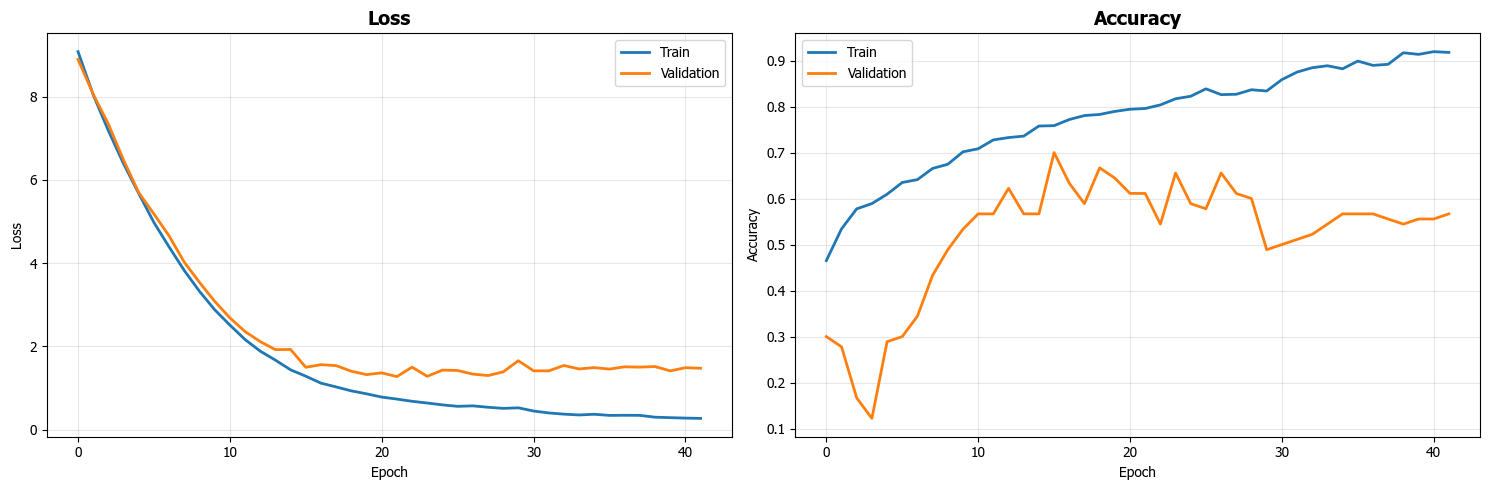


STEP 5: Dashboard Visualization


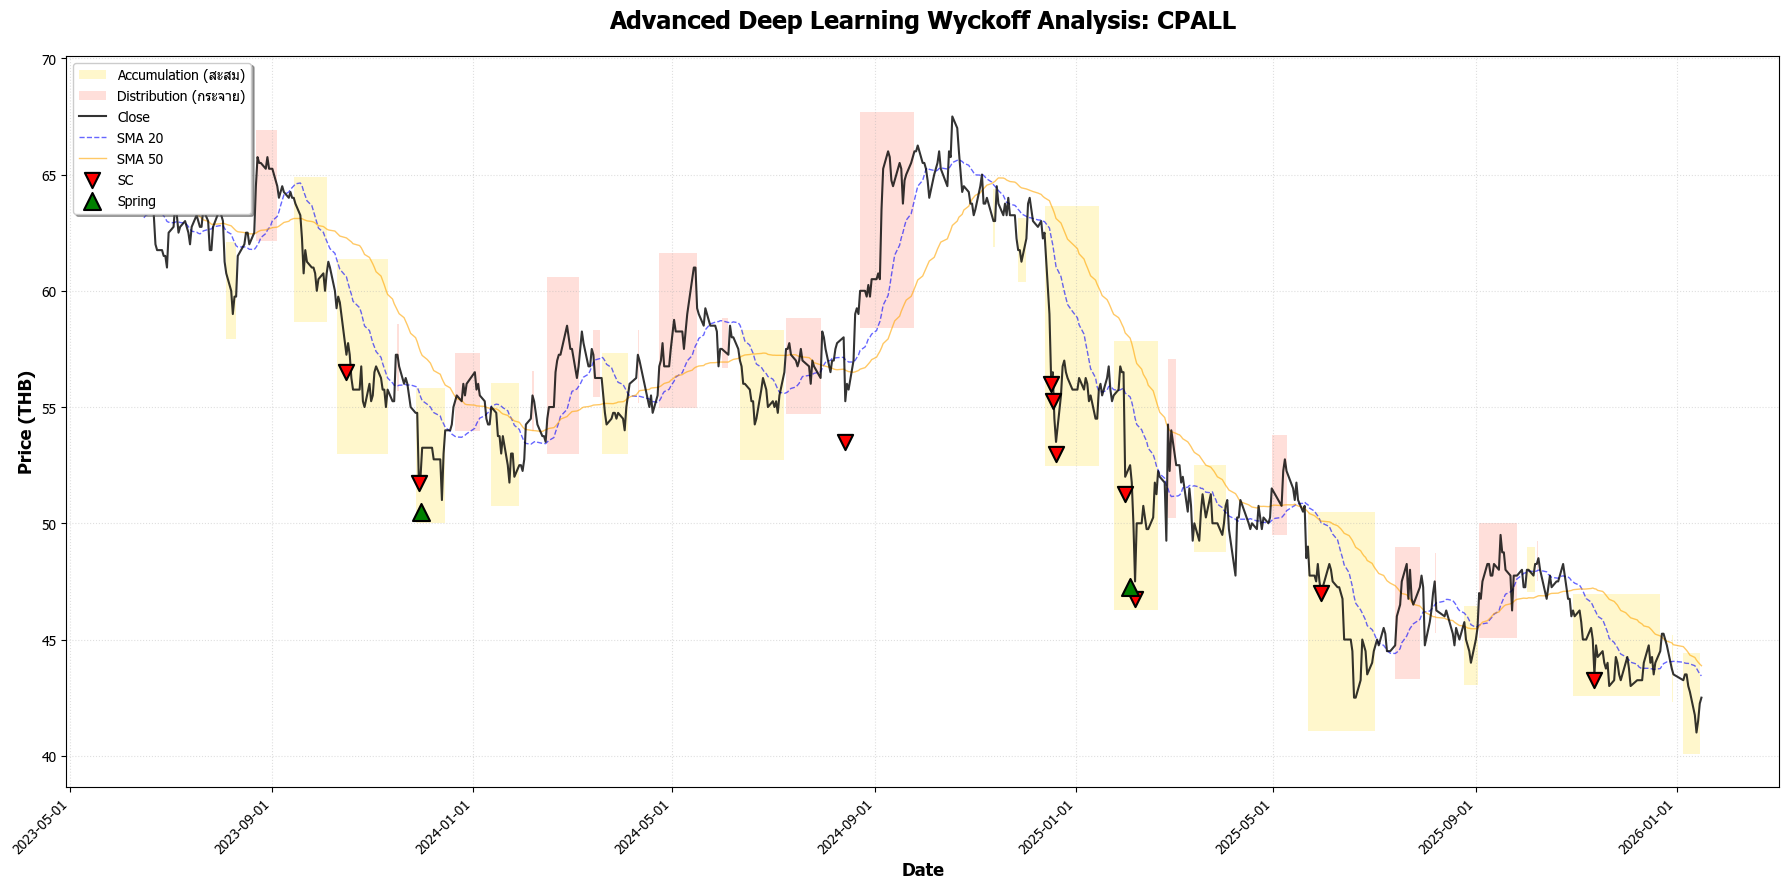


STEP 6: Model Evaluation

📋 Classification Report:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

      Normal     0.7143    0.4348    0.5405        46
Accumulation     0.5909    0.8667    0.7027        30
Distribution     0.5000    0.6429    0.5625        14

    accuracy                         0.6111        90
   macro avg     0.6017    0.6481    0.6019        90
weighted avg     0.6398    0.6111    0.5980        90



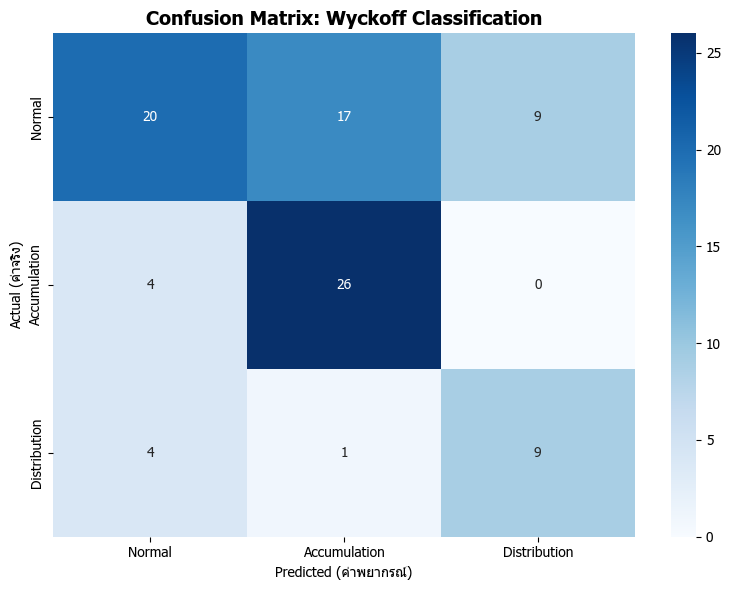


🎯 PREDICTED ZONE DISTRIBUTION
Normal          :   258 bars ( 40.95%)
Accumulation    :   230 bars ( 36.51%)
Distribution    :   142 bars ( 22.54%)

🏆 FINAL RESULTS
Best Validation Loss     : 1.2726
Best Validation Accuracy : 0.7000 (70.00%)
Best Training Accuracy   : 0.9192 (91.92%)
F1 Score (Weighted)      : 0.5980
Overfitting Gap          : 21.92%
✅ Process completed successfully!
💾 Best model saved as: best_wyckoff_dl_model.h5


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.dates as mdates
import seaborn as sns
from cassandra.cluster import Cluster
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (LSTM, Dense, Dropout, GRU, Bidirectional,
                                     Input, Concatenate, BatchNormalization,
                                     GlobalAveragePooling1D, Attention)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import AdamW
import warnings
warnings.filterwarnings('ignore')

# ========================================
# 1. Configuration
# ========================================
CASSANDRA_HOST = '127.0.0.1'
CASSANDRA_PORT = 9042
SYMBOL = 'CPALL'
WINDOW_SIZE = 30
LEARNING_RATE = 0.0003
EPOCHS = 120
BATCH_SIZE = 16

# ========================================
# 2. Data Loading
# ========================================
def get_data(symbol):
    try:
        cluster = Cluster([CASSANDRA_HOST], port=CASSANDRA_PORT)
        session = cluster.connect('data_stock')
        query = f"SELECT symbol, time, open, high, low, close, volume FROM candlestick_data WHERE symbol = '{symbol}' LIMIT 3000 ALLOW FILTERING"
        df = pd.DataFrame(list(session.execute(query)))
        df['time'] = pd.to_datetime(df['time'])
        df.sort_values('time', inplace=True)
        cluster.shutdown()
        print(f"✅ Successfully loaded {len(df)} records for {symbol}")
        return df.reset_index(drop=True)
    except Exception as e:
        print(f"❌ Connection Error: {e}")
        return None

# ========================================
# 3. Advanced Technical Indicators
# ========================================
def calculate_rsi(series, period=14):
    """RSI with improved calculation"""
    delta = series.diff()
    gain = delta.clip(lower=0).rolling(window=period, min_periods=1).mean()
    loss = (-delta.clip(upper=0)).rolling(window=period, min_periods=1).mean()
    rs = gain / (loss + 1e-10)
    return 100 - (100 / (1 + rs))

def calculate_macd(series):
    """MACD with histogram"""
    ema_12 = series.ewm(span=12).mean()
    ema_26 = series.ewm(span=26).mean()
    macd = ema_12 - ema_26
    signal = macd.ewm(span=9).mean()
    histogram = macd - signal
    return macd, signal, histogram

def calculate_bbands(series, period=20):
    """Bollinger Bands"""
    sma = series.rolling(period).mean()
    std = series.rolling(period).std()
    upper = sma + (2 * std)
    lower = sma - (2 * std)
    bb_position = (series - lower) / (upper - lower + 1e-10)
    bb_width = (upper - lower) / sma
    return bb_position, bb_width

def calculate_stochastic(df, period=14):
    """Stochastic Oscillator"""
    low_min = df['low'].rolling(period).min()
    high_max = df['high'].rolling(period).max()
    k = 100 * (df['close'] - low_min) / (high_max - low_min + 1e-10)
    d = k.rolling(3).mean()
    return k, d

def calculate_obv(df):
    """On-Balance Volume"""
    obv = (np.sign(df['close'].diff()) * df['volume']).fillna(0).cumsum()
    return obv

def calculate_mfi(df, period=14):
    """Money Flow Index"""
    typical_price = (df['high'] + df['low'] + df['close']) / 3
    money_flow = typical_price * df['volume']
    
    positive_flow = pd.Series(0.0, index=df.index)
    negative_flow = pd.Series(0.0, index=df.index)
    
    positive_flow[typical_price > typical_price.shift(1)] = money_flow[typical_price > typical_price.shift(1)]
    negative_flow[typical_price < typical_price.shift(1)] = money_flow[typical_price < typical_price.shift(1)]
    
    mfr = positive_flow.rolling(period).sum() / (negative_flow.rolling(period).sum() + 1e-10)
    mfi = 100 - (100 / (1 + mfr))
    return mfi

# ========================================
# 4. Comprehensive Feature Engineering
# ========================================
def prepare_advanced_features(df):
    """Create 35+ advanced features"""
    df = df.copy()
    
    # === Basic Price Features ===
    df['returns'] = df['close'].pct_change()
    df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
    df['high_low_spread'] = (df['high'] - df['low']) / df['close']
    df['close_open_spread'] = (df['close'] - df['open']) / df['open']
    df['high_low_ratio'] = df['high'] / df['low']
    
    # === Volume Features ===
    for period in [5, 10, 20, 30]:
        df[f'volume_ma_{period}'] = df['volume'].rolling(period).mean()
        df[f'volume_ratio_{period}'] = df['volume'] / (df[f'volume_ma_{period}'] + 1)
    
    df['volume_momentum'] = df['volume'].pct_change(5)
    df['volume_std'] = df['volume'].rolling(20).std()
    
    # === Moving Averages ===
    for period in [5, 10, 20, 50, 100]:
        df[f'sma_{period}'] = df['close'].rolling(period).mean()
        df[f'ema_{period}'] = df['close'].ewm(span=period).mean()
    
    # === Distance from MAs ===
    for period in [10, 20, 50]:
        df[f'dist_from_sma_{period}'] = (df['close'] - df[f'sma_{period}']) / df[f'sma_{period}']
        df[f'dist_from_ema_{period}'] = (df['close'] - df[f'ema_{period}']) / df[f'ema_{period}']
    
    # === Technical Indicators ===
    df['rsi'] = calculate_rsi(df['close'], 14)
    df['rsi_slope'] = df['rsi'].diff(5)
    
    df['macd'], df['macd_signal'], df['macd_hist'] = calculate_macd(df['close'])
    df['macd_cross'] = (df['macd'] > df['macd_signal']).astype(int)
    
    df['stoch_k'], df['stoch_d'] = calculate_stochastic(df)
    df['bb_position'], df['bb_width'] = calculate_bbands(df['close'])
    
    df['obv'] = calculate_obv(df)
    df['obv_slope'] = df['obv'].diff(5)
    df['mfi'] = calculate_mfi(df, 14)
    
    # === Volatility ===
    for period in [5, 10, 20]:
        df[f'volatility_{period}'] = df['returns'].rolling(period).std()
        df[f'atr_{period}'] = df['high_low_spread'].rolling(period).mean()
    
    # === Price Action ===
    df['body'] = abs(df['close'] - df['open'])
    df['upper_shadow'] = df['high'] - df[['close', 'open']].max(axis=1)
    df['lower_shadow'] = df[['close', 'open']].min(axis=1) - df['low']
    df['body_pct'] = df['body'] / (df['high_low_spread'] + 1e-10)
    df['upper_shadow_pct'] = df['upper_shadow'] / (df['high_low_spread'] + 1e-10)
    df['lower_shadow_pct'] = df['lower_shadow'] / (df['high_low_spread'] + 1e-10)
    
    # === Momentum ===
    for period in [5, 10, 20]:
        df[f'momentum_{period}'] = df['close'].diff(period)
        df[f'roc_{period}'] = df['close'].pct_change(period)
    
    # === Trend Features ===
    df['price_above_sma20'] = (df['close'] > df['sma_20']).astype(int)
    df['price_above_sma50'] = (df['close'] > df['sma_50']).astype(int)
    df['sma_trend'] = (df['sma_20'] > df['sma_50']).astype(int)
    
    # === Wyckoff Events ===
    df['high_volume'] = (df['volume'] > df['volume_ma_30'] * 2.0).astype(int)
    df['SC'] = ((df['high_volume'] == 1) & 
                (df['low'] == df['low'].rolling(30).min()) &
                (df['close'] < df['open'])).astype(int)
    df['BC'] = ((df['high_volume'] == 1) & 
                (df['high'] == df['high'].rolling(30).max()) &
                (df['close'] < df['open'])).astype(int)
    
    # AR Detection
    df['AR'] = 0
    for i in df.index[df['SC'] | df['BC']]:
        if i + 10 < len(df):
            if df.loc[i, 'SC']:
                ar_idx = df.loc[i:i+10, 'high'].idxmax()
            else:
                ar_idx = df.loc[i:i+10, 'low'].idxmin()
            df.at[ar_idx, 'AR'] = 1
    
    # Spring Detection
    support = df['low'].rolling(60).min().shift(1)
    df['SPRING'] = ((df['low'] < support) & 
                    (df['close'] > support) & 
                    (df['high_volume'] == 1) &
                    (df['close'] > df['open'])).astype(int)
    
    return df.dropna().reset_index(drop=True)

# ========================================
# 5. Smart Multi-Strategy Target Labeling
# ========================================
def create_smart_targets(df):
    """Multi-strategy voting system for balanced targets"""
    df = df.copy()
    df['target'] = 0
    
    # Thresholds
    volume_high = df['volume_ratio_30'] > df['volume_ratio_30'].quantile(0.70)
    
    # Strategy 1: Price + Volume
    price_low = df['close'] < df['sma_50']
    price_high = df['close'] > df['sma_50']
    
    # Strategy 2: RSI
    rsi_oversold = df['rsi'] < 40
    rsi_overbought = df['rsi'] > 60
    
    # Strategy 3: MFI
    mfi_oversold = df['mfi'] < 35
    mfi_overbought = df['mfi'] > 65
    
    # Strategy 4: Bollinger Bands
    bb_low = df['bb_position'] < 0.25
    bb_high = df['bb_position'] > 0.75
    
    # Strategy 5: Stochastic
    stoch_oversold = df['stoch_k'] < 20
    stoch_overbought = df['stoch_k'] > 80
    
    # Strategy 6: MACD
    macd_bullish = (df['macd'] > df['macd_signal']) & (df['macd_hist'] > 0)
    macd_bearish = (df['macd'] < df['macd_signal']) & (df['macd_hist'] < 0)
    
    # Accumulation Voting
    accum_votes = (
        (price_low & volume_high).astype(int) +
        rsi_oversold.astype(int) +
        mfi_oversold.astype(int) +
        bb_low.astype(int) +
        stoch_oversold.astype(int) +
        macd_bullish.astype(int) +
        (df['close'] > df['open']).astype(int)
    )
    
    # Distribution Voting
    dist_votes = (
        (price_high & volume_high).astype(int) +
        rsi_overbought.astype(int) +
        mfi_overbought.astype(int) +
        bb_high.astype(int) +
        stoch_overbought.astype(int) +
        macd_bearish.astype(int) +
        (df['close'] < df['open']).astype(int)
    )
    
    # Assign labels (need 3+ votes)
    df.loc[accum_votes >= 3, 'target'] = 1
    df.loc[dist_votes >= 3, 'target'] = 2
    
    # Resolve conflicts
    conflicts = (accum_votes >= 3) & (dist_votes >= 3)
    df.loc[conflicts & (accum_votes > dist_votes), 'target'] = 1
    df.loc[conflicts & (dist_votes > accum_votes), 'target'] = 2
    
    print("\n" + "="*80)
    print("TARGET DISTRIBUTION (Multi-Strategy Voting)")
    print("="*80)
    target_counts = df['target'].value_counts().sort_index()
    for label, count in target_counts.items():
        pct = (count / len(df)) * 100
        label_name = ['Normal', 'Accumulation', 'Distribution'][label]
        print(f"{label_name:15} : {count:5} ({pct:6.2f}%)")
    
    return df

# ========================================
# 6. Data Augmentation
# ========================================
def augment_sequences(X, y, augment_factor=2):
    """Time series augmentation"""
    X_aug, y_aug = [X], [y]
    
    for _ in range(augment_factor):
        # Jittering
        noise = np.random.normal(0, 0.01, X.shape)
        X_jittered = X + noise
        X_aug.append(X_jittered)
        y_aug.append(y)
        
        # Scaling
        scale = np.random.uniform(0.98, 1.02, (X.shape[0], 1, 1))
        X_scaled = X * scale
        X_aug.append(X_scaled)
        y_aug.append(y)
    
    return np.concatenate(X_aug), np.concatenate(y_aug)

# ========================================
# 7. Advanced Hybrid Model
# ========================================
def create_hybrid_model(input_shape, num_classes=3):
    """Hybrid LSTM + GRU + Attention model"""
    inputs = Input(shape=input_shape)
    
    # Branch 1: Bidirectional LSTM
    lstm_out = Bidirectional(LSTM(80, return_sequences=True))(inputs)
    lstm_out = BatchNormalization()(lstm_out)
    lstm_out = Dropout(0.35)(lstm_out)
    
    # Branch 2: Bidirectional GRU
    gru_out = Bidirectional(GRU(80, return_sequences=True))(inputs)
    gru_out = BatchNormalization()(gru_out)
    gru_out = Dropout(0.35)(gru_out)
    
    # Merge branches
    merged = Concatenate()([lstm_out, gru_out])
    
    # Additional LSTM layer
    x = LSTM(64, return_sequences=True)(merged)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # Global Average Pooling
    pooled = GlobalAveragePooling1D()(x)
    
    # Dense layers
    dense = Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(pooled)
    dense = BatchNormalization()(dense)
    dense = Dropout(0.4)(dense)
    
    dense = Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(dense)
    dense = BatchNormalization()(dense)
    dense = Dropout(0.3)(dense)
    
    outputs = Dense(num_classes, activation='softmax')(dense)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# ========================================
# 8. Advanced Training
# ========================================
def train_advanced_dl_model(df, window_size=WINDOW_SIZE):
    """Train with advanced techniques"""
    
    # Select features
    feature_cols = [
        'returns', 'log_returns', 'volume_ratio_10', 'volume_ratio_30',
        'rsi', 'rsi_slope', 'macd', 'macd_hist',
        'stoch_k', 'stoch_d', 'mfi', 'obv_slope',
        'dist_from_sma_10', 'dist_from_sma_20', 'dist_from_sma_50',
        'dist_from_ema_10', 'dist_from_ema_20',
        'volatility_5', 'volatility_20', 'atr_10',
        'bb_position', 'bb_width',
        'body_pct', 'upper_shadow_pct', 'lower_shadow_pct',
        'momentum_5', 'momentum_20',
        'sma_trend', 'price_above_sma20'
    ]
    
    # RobustScaler
    scaler = RobustScaler()
    scaled_data = scaler.fit_transform(df[feature_cols])
    
    # Create sequences
    X, y = [], []
    for i in range(window_size, len(scaled_data)):
        X.append(scaled_data[i-window_size:i])
        y.append(df['target'].iloc[i])
    
    X = np.array(X)
    y = np.array(y)
    
    print(f"\n📊 Original dataset: {len(X)} samples")
    
    # Split
    split = int(len(X) * 0.85)
    X_train, X_val = X[:split], X[split:]
    y_train, y_val = y[:split], y[split:]
    
    # Data Augmentation
    print("🔄 Applying data augmentation...")
    X_train_aug, y_train_aug = augment_sequences(X_train, y_train, augment_factor=2)
    print(f"📈 Augmented dataset: {len(X_train_aug)} samples")
    
    # Class weights
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(y_train_aug),
        y=y_train_aug
    )
    class_weight_dict = dict(enumerate(class_weights))
    
    print("\n⚖️  Class Weights:")
    for cls, weight in class_weight_dict.items():
        print(f"   Class {cls}: {weight:.3f}")
    
    # Create model
    model = create_hybrid_model((window_size, len(feature_cols)))
    
    # Optimizer
    optimizer = AdamW(learning_rate=LEARNING_RATE, weight_decay=0.001)
    
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print(f"\n🏗️  Model Architecture:")
    print(f"   Total Parameters: {model.count_params():,}")
    
    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=8,
            min_lr=1e-7,
            verbose=1
        ),
        ModelCheckpoint(
            'best_wyckoff_dl_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]
    
    # Training
    print("\n🚀 Training Advanced Deep Learning Model...")
    print("="*80)
    
    history = model.fit(
        X_train_aug, y_train_aug,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        class_weight=class_weight_dict,
        callbacks=callbacks,
        verbose=1
    )
    
    # Predictions
    df['dl_zone'] = 0
    full_preds = np.argmax(model.predict(X, verbose=0), axis=1)
    df.iloc[window_size:, df.columns.get_loc('dl_zone')] = full_preds
    
    return df, model, history, (X_val, y_val), scaler

# ========================================
# 9. Visualization
# ========================================
def plot_dashboard(df):
    """Enhanced dashboard"""
    plt.rcParams['font.family'] = 'Tahoma'
    plt.rcParams['axes.unicode_minus'] = False
    
    fig, ax = plt.subplots(figsize=(18, 9))
    
    zone_types = {
        1: ('#FFD700', 'Accumulation (สะสม)'),
        2: ('#FF6347', 'Distribution (กระจาย)')
    }
    
    for zone_id, (color, label_name) in zone_types.items():
        subset = df[df['dl_zone'] == zone_id].copy()
        
        if len(subset) > 0:
            start_t = subset['time'].iloc[0]
            
            for i in range(1, len(subset)):
                time_gap = (subset['time'].iloc[i] - subset['time'].iloc[i-1]).days
                is_last = (i == len(subset) - 1)
                
                if time_gap > 5 or is_last:
                    end_t = subset['time'].iloc[i] if is_last else subset['time'].iloc[i-1]
                    box_data = df[(df['time'] >= start_t) & (df['time'] <= end_t)]
                    
                    if len(box_data) > 0:
                        rect_start = mdates.date2num(start_t)
                        rect_width = mdates.date2num(end_t) - rect_start
                        y_min = box_data['low'].min() * 0.99
                        y_max = box_data['high'].max() * 1.01
                        
                        rect = patches.Rectangle(
                            (rect_start, y_min), rect_width, y_max - y_min,
                            linewidth=0, facecolor=color, alpha=0.2,
                            label=label_name, zorder=1
                        )
                        ax.add_patch(rect)
                    
                    start_t = subset['time'].iloc[i]
    
    ax.plot(df['time'], df['close'], 'k-', linewidth=1.5, label='Close', zorder=3, alpha=0.8)
    ax.plot(df['time'], df['sma_20'], 'b--', linewidth=1, label='SMA 20', alpha=0.6)
    ax.plot(df['time'], df['sma_50'], color='orange', linewidth=1, label='SMA 50', alpha=0.6)
    
    for event, marker, color, size, label in [
        ('SC', 'v', 'red', 120, 'SC'),
        ('AR', 'D', 'blue', 80, 'AR'),
        ('SPRING', '^', 'green', 150, 'Spring')
    ]:
        points = df[df[event] == 1]
        if len(points) > 0:
            y_val = points['low'] if event in ['SC', 'SPRING'] else points['high']
            ax.scatter(points['time'], y_val, color=color, marker=marker, s=size,
                      edgecolor='black' if event != 'AR' else 'white',
                      linewidth=1.5, label=label, zorder=10)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45, ha='right')
    ax.set_title(f'Advanced Deep Learning Wyckoff Analysis: {SYMBOL}', 
                fontsize=18, fontweight='bold', pad=20)
    ax.set_xlabel('Date', fontsize=13, fontweight='bold')
    ax.set_ylabel('Price (THB)', fontsize=13, fontweight='bold')
    
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper left', 
             fontsize=10, frameon=True, shadow=True)
    
    ax.grid(True, linestyle=':', alpha=0.4)
    plt.tight_layout()
    plt.show()

def plot_training_history(history):
    """Plot training history"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    axes[0].plot(history.history['loss'], label='Train', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Validation', linewidth=2)
    axes[0].set_title('Loss', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    axes[1].plot(history.history['accuracy'], label='Train', linewidth=2)
    axes[1].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    axes[1].set_title('Accuracy', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ========================================
# 10. Main Execution
# ========================================
if __name__ == "__main__":
    print("\n" + "="*80)
    print(" " * 15 + "🚀 ADVANCED DEEP LEARNING WYCKOFF ANALYSIS 🚀")
    print("="*80)
    
    df_raw = get_data(SYMBOL)
    
    if df_raw is not None:
        # Feature Engineering
        print("\n" + "="*80)
        print("STEP 1: Advanced Feature Engineering (35+ features)")
        print("="*80)
        df_feat = prepare_advanced_features(df_raw)
        print(f"✅ Created {len(df_feat.columns)} columns")
        
        # Target Labeling
        print("\n" + "="*80)
        print("STEP 2: Smart Target Labeling")
        print("="*80)
        df_labeled = create_smart_targets(df_feat)
        
        # Train Model
        print("\n" + "="*80)
        print("STEP 3: Hybrid Model Training (LSTM+GRU)")
        print("="*80)
        df_final, model, history, (X_val, y_val), scaler = train_advanced_dl_model(df_labeled)
        
        # Training History
        print("\n" + "="*80)
        print("STEP 4: Training Visualization")
        print("="*80)
        plot_training_history(history)
        
        # Dashboard
        print("\n" + "="*80)
        print("STEP 5: Dashboard Visualization")
        print("="*80)
        plot_dashboard(df_final)
        
        # Evaluation
        print("\n" + "="*80)
        print("STEP 6: Model Evaluation")
        print("="*80)
        y_pred = np.argmax(model.predict(X_val, verbose=0), axis=1)
        
        print("\n📋 Classification Report:")
        print("-" * 80)
        print(classification_report(y_val, y_pred,
                                   target_names=['Normal', 'Accumulation', 'Distribution'],
                                   digits=4))
        
        # Confusion Matrix
        fig, ax = plt.subplots(figsize=(8, 6))

        # คำนวณ Confusion Matrix โดยระบุ labels เพื่อป้องกันกรณีข้อมูลไม่ครบทุกคลาส
        unique_val_classes = np.unique(y_val)
        cm = confusion_matrix(y_val, y_pred, labels=unique_val_classes)

        # ใช้ชื่อ labels ตามที่มีจริงในข้อมูล
        target_names = ['Normal', 'Accumulation', 'Distribution']
        valid_labels = [target_names[i] for i in unique_val_classes]

        # เปลี่ยน cmap เป็น 'Blues' (สีมาตรฐาน ดูง่าย สบายตา)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=valid_labels,
                yticklabels=valid_labels)

        plt.title('Confusion Matrix: Wyckoff Classification', fontsize=14, fontweight='bold')
        plt.ylabel('Actual (ค่าจริง)')
        plt.xlabel('Predicted (ค่าพยากรณ์)')
        plt.tight_layout()
        plt.show()
        
        # Summary
        zone_dist = df_final['dl_zone'].value_counts().sort_index()
        zone_names = {0: 'Normal', 1: 'Accumulation', 2: 'Distribution'}
        
        print("\n" + "="*80)
        print("🎯 PREDICTED ZONE DISTRIBUTION")
        print("="*80)
        for zone_id, count in zone_dist.items():
            pct = (count / len(df_final)) * 100
            print(f"{zone_names[zone_id]:15} : {count:5} bars ({pct:6.2f}%)")
        
        # Final Metrics
        best_val_loss = min(history.history['val_loss'])
        best_val_acc = max(history.history['val_accuracy'])
        best_train_acc = max(history.history['accuracy'])
        f1 = f1_score(y_val, y_pred, average='weighted')
        
        print("\n" + "="*80)
        print("🏆 FINAL RESULTS")
        print("="*80)
        print(f"Best Validation Loss     : {best_val_loss:.4f}")
        print(f"Best Validation Accuracy : {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
        print(f"Best Training Accuracy   : {best_train_acc:.4f} ({best_train_acc*100:.2f}%)")
        print(f"F1 Score (Weighted)      : {f1:.4f}")
        print(f"Overfitting Gap          : {(best_train_acc - best_val_acc)*100:.2f}%")
        print("="*80)
        print("✅ Process completed successfully!")
        print("💾 Best model saved as: best_wyckoff_dl_model.h5")
        print("="*80)
        
    else:
        print("\n❌ Failed to load data")